In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt

# import mxnet as mx


Using Theano backend.


In [243]:
base_image_path = "ucsd.jpg"
style_reference_image_path = "vango.jpg"
# result_prefix = "res"
iterations = 30

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025 

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

[[[[ 0.44921875  0.48828125  0.73046875]
   [ 0.4453125   0.48046875  0.734375  ]
   [ 0.453125    0.48828125  0.7421875 ]
   ..., 
   [ 0.38671875  0.44140625  0.71875   ]
   [ 0.38671875  0.4453125   0.71484375]
   [ 0.40234375  0.44140625  0.7109375 ]]

  [[ 0.44921875  0.48828125  0.73046875]
   [ 0.4453125   0.48046875  0.734375  ]
   [ 0.453125    0.48828125  0.7421875 ]
   ..., 
   [ 0.38671875  0.4453125   0.70703125]
   [ 0.38671875  0.4453125   0.70703125]
   [ 0.3984375   0.4375      0.70703125]]

  [[ 0.4453125   0.484375    0.7265625 ]
   [ 0.44921875  0.484375    0.73828125]
   [ 0.44921875  0.484375    0.73828125]
   ..., 
   [ 0.38671875  0.4375      0.703125  ]
   [ 0.39453125  0.44921875  0.703125  ]
   [ 0.41015625  0.4453125   0.71484375]]

  ..., 
  [[ 0.80859375  0.5234375   0.08203125]
   [ 0.73046875  0.47265625  0.09375   ]
   [ 0.53125     0.3046875   0.015625  ]
   ..., 
   [ 0.40234375  0.203125    0.01953125]
   [ 0.4140625   0.21875     0.01171875]
   [ 0.

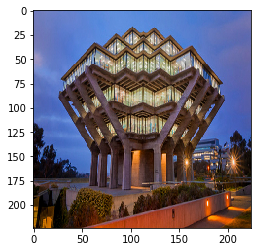

[[[[ 0.04296875  0.09375     0.30078125]
   [ 0.09375     0.109375    0.34765625]
   [ 0.109375    0.07421875  0.1796875 ]
   ..., 
   [ 0.87890625  0.96484375  0.78515625]
   [ 0.83203125  0.84375     0.32421875]
   [ 0.78125     0.7578125   0.2734375 ]]

  [[ 0.12109375  0.25390625  0.5       ]
   [ 0.13671875  0.20703125  0.46484375]
   [ 0.12890625  0.10546875  0.20703125]
   ..., 
   [ 0.52734375  0.6484375   0.91015625]
   [ 0.4765625   0.625       0.42578125]
   [ 0.765625    0.76171875  0.265625  ]]

  [[ 0.03515625  0.27734375  0.515625  ]
   [ 0.1875      0.3125      0.55078125]
   [ 0.1953125   0.171875    0.2734375 ]
   ..., 
   [ 0.1953125   0.32421875  0.2109375 ]
   [ 0.11328125  0.35546875  0.890625  ]
   [ 0.49609375  0.66796875  0.6171875 ]]

  ..., 
  [[ 0.109375    0.1015625   0.14453125]
   [ 0.0859375   0.078125    0.12890625]
   [ 0.109375    0.1015625   0.15625   ]
   ..., 
   [ 0.109375    0.0859375   0.1328125 ]
   [ 0.11328125  0.08984375  0.12890625]
   [ 0.

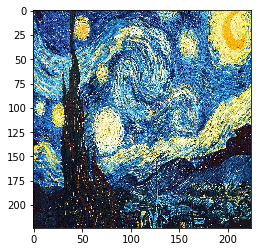

In [244]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0/ 256
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    print img 
    plt.imshow(img[0])
    plt.show()
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_nrows, img_ncols, 3))



In [263]:
# input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

# model = vgg16.VGG16(input_tensor=input_tensor,
#                     weights='imagenet', include_top=False)
# print('Model loaded.')

# # get the symbolic outputs of each "key" layer (we gave them unique names).
# outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])



In [299]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



In [300]:
# # combine these loss functions into a single scalar
# loss = K.variable(0.)
# layer_features = outputs_dict['block4_conv2']
# base_image_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]
# loss += content_weight * content_loss(base_image_features,
#                                       combination_features)

# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']
# for layer_name in feature_layers:
#     layer_features = outputs_dict[layer_name]
#     style_reference_features = layer_features[1, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     sl = style_loss(style_reference_features, combination_features)
#     loss += (style_weight / len(feature_layers)) * sl
# loss += total_variation_weight * total_variation_loss(combination_image)

# grads = K.gradients(loss, combination_image)

# outputs = [loss]
# # if isinstance(grads, (list, tuple)):
# #     outputs += grads
# # else:
# #     outputs.append(grads)

# f_outputs = K.function([combination_image], outputs)




In [301]:
# # combine these loss functions into a single scalar
# loss = K.variable(0.)
# layer_features = outputs_dict['block4_conv2']
# base_image_features = layer_features[0, :, :, :]
# combination_features = layer_features[2, :, :, :]
# loss += content_weight * content_loss(base_image_features,
#                                       combination_features)

# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']
# for layer_name in feature_layers:
#     layer_features = outputs_dict[layer_name]
#     style_reference_features = layer_features[1, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     sl = style_loss(style_reference_features, combination_features)
#     loss += (style_weight / len(feature_layers)) * sl
# loss += total_variation_weight * total_variation_loss(combination_image)

# # grads = K.gradients(loss, combination_image)

# outputs = [loss]
# # if isinstance(grads, (list, tuple)):
# #     outputs += grads
# # else:
# #     outputs.append(grads)

# f_outputs = K.function([combination_image], outputs)




In [302]:
# base_image_path = "vango2.jpg"
# style_reference_image_path = "vango2.jpg"
# # result_prefix = "res"
# iterations = 30

# total_variation_weight = 1.0
# style_weight = 1.0
# content_weight = 0.025 

# width, height = load_img(base_image_path).size
# img_nrows = 224
# img_ncols = 224#int(width * img_nrows / height)

In [303]:
# def preprocess_image(image_path):
#     img = load_img(image_path, target_size=(img_nrows, img_ncols))
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) / 256
#     return img

# base_image = K.variable(preprocess_image(base_image_path))
# style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# combination_image = K.placeholder((1, img_nrows, img_ncols, 3))



In [304]:
# input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

# model1 = vgg16.VGG16(input_tensor=input_tensor,
#                     weights='imagenet', include_top=False)
# print('Model loaded.')

# # get the symbolic outputs of each "key" layer (we gave them unique names).
# outputs_dict = dict([(layer.name, layer.output) for layer in model1.layers])



In [305]:
# def get_loss(y_true, y_pred):
# #     print "yT", y_true
# #     print "yP", y_pred
#     loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
# #     loss += 0.25 * content_loss(base_image[0, :, :, :], y_pred[0, :, :, :])
#     print "loss", K.shape(loss), loss
#     return loss

def get_loss2(y_true, y_pred):
    sty = style_reference_image - 0.5
    combo =  y_pred * 0.5
#     combo = vgg16.preprocess_input(combo)
    base = base_image - 0.5
#     loss = style_loss(sty[0, :, :, :], combo[0, :, :, :])
#     loss += 0.25 * content_loss(base[0, :, :, :], combo[0, :, :, :])
#     print "loss", K.shape(loss), loss
    input_tensor = K.concatenate([base,
                                  sty,
                                  combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor,
                        weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features,
                                          combination_features)
#     print loss
    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
#     print loss,
    loss += total_variation_weight * total_variation_loss(combo)
#     print loss,
    return loss 



# def mean_squared_error(y_true, y_pred):
#     return K.mean(K.square(y_pred - y_true), axis=-1)


# def my_loss(y_true, y_pred):
#     model1 = vgg16.VGG16(weights='imagenet', include_top=False)
#     print type(y_true), y_true
#     out_true = model1.predict(y_true)
#     out_pred = model1.predict(y_pred)
# #     return K.variable(0.)
#     return get_loss(out_true, out_pred)

def my_loss_2(y_true, y_pred):
#     print type(y_pred.eval())
    print y_pred.eval()
    outs = f_outputs([y_pred])
    loss_value = outs[0]
    return loss_value


# def get_actual_loss(y_true, y_pred):
# #     return mean_squared_error(y_true, y_pred)

# #     img11 = vgg16.preprocess_input(y_pred)
#     combination_image = y_pred#K.variable(img11)
#     style_reference_image = y_true
# #     base_image = K.variable(preprocess_image(base_image_path))
    
#     input_tensor = K.concatenate([base_image,
#                               style_reference_image,
#                               combination_image], axis=0)

#     model1 = vgg16.VGG16(input_tensor=input_tensor,
#                         weights='imagenet', include_top=False)
# #     print('Model loaded.')

#     # get the symbolic outputs of each "key" layer (we gave them unique names).
#     outputs_dict = dict([(layer.name, layer.output) for layer in model1.layers])

    
#     loss = K.variable(0.)
#     layer_features = outputs_dict['block4_conv2']
#     base_image_features = layer_features[0, :, :, :]
#     combination_features = layer_features[2, :, :, :]
#     loss += content_weight * content_loss(base_image_features,
#                                           combination_features)
#     return loss
# #     feature_layers = ['block1_conv1', 'block2_conv1',
# #                       'block3_conv1', 'block4_conv1',
# #                       'block5_conv1']
# #     for layer_name in feature_layers:
# #         layer_features = outputs_dict[layer_name]
# #         style_reference_features = layer_features[1, :, :, :]
# #         combination_features = layer_features[2, :, :, :]
# #         sl = style_loss(style_reference_features, combination_features)
# #         loss += (style_weight / len(feature_layers)) * sl
# #     loss += total_variation_weight * total_variation_loss(combination_image)
# #     return loss
# #     outputs = [loss]

# #     f_outputs = K.function([combination_image], outputs)
# #     outs = f_outputs([combination_image])
# #     loss_value = outs[0]
# #     return loss_value



In [306]:
# print type(inpY)
# print my_loss_2(base_image, base_image)
# base_image.eval()
# print np.min(base_image[:, :, :, 2].eval() - 0.5), np.max(base_image[:, :, :, 2].eval() - 0.5)

In [307]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))
inputs_ = Input(shape=( 224,224,3, ))


# Layer 1
x1 = Dense(100, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
# x = Reshape((16, 7, 7))(x)
x = Reshape((56, 56, 64))(x)

# Layer 3
x = UpSampling2D(size = (2, 2), dim_ordering = 'tf')(x) 
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'tanh')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

# vgg_model = VGG16(weights = 'imagenet', include_top = False)
# for layer in vgg_model.layers:
#     layer.trainable = False
# outp_vgg = vgg_model.output

# # Discriminative model
# disc_model = Model(input = vgg_model.input, output = vgg_model.layers[8].output)

In [308]:
# model = Sequential()
# model.add(generative_model)
# model.add(disc_model)
generative_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_61 (InputLayer)            (None, 150528)        0                                            
____________________________________________________________________________________________________
dense_31 (Dense)                 (None, 100)           15052900    input_61[0][0]                   
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 200704)        20271104    dense_31[0][0]                   
____________________________________________________________________________________________________
batchnormalization_16 (BatchNorm (None, 200704)        802816      dense_32[0][0]                   
___________________________________________________________________________________________

In [309]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
# img = inp
# print img.shape
# # img = img.swapaxes(0, 2)#.swapaxes(0, 1)
# plt.imshow(img )
# plt.show()



# inp = inp.swapaxes(0, 1)
print "basic", inp.shape
inpY = 1.0 * np.reshape(inp, (1,224, 224, 3)) 
# trainY = disc_model.predict([inp])
# trainY2 = disc_model.predict([inp * 1.0/256])
# print trainY2.shape

# import Image
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
# inp = inp.swapaxes(0, 1)
trainX = np.reshape(inp, (1, 224, 224, 3))
# trainX = disc_model.predict([inp])

trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))

trainX3 = trainX2 * 1.0/256

# trainX3 = trainX * 1.0/256


inpY = inpY*1.0 / 256
print trainX3.shape
print inpY.shape

basic (50176, 3)
(1, 150528)
(1, 224, 224, 3)


In [310]:
# print trainX3
# print ""
# print inpY
# generative_model.summary()

In [311]:
# import keras
# adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# # sgd = SGD(lr=5, momentum=0.9, nesterov=True)
# model.compile(loss = get_loss
#               , optimizer = adam_op)

In [312]:
# model.fit(trainX3, trainY2, nb_epoch = 0)
# # generative_model.summary()

In [313]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(
                loss = get_loss2,
#                 loss = my_loss_2,
              optimizer = adam_op)
# print trainX3.shape, inpY.shape


Model loaded.


Epoch 1/10
1/1 [==============================] - 7s - loss: 165083.6562
Epoch 2/10
1/1 [==============================] - 7s - loss: 164357.3750
Epoch 3/10
1/1 [==============================] - 6s - loss: 163338.5625
Epoch 4/10
1/1 [==============================] - 7s - loss: 162475.8906
Epoch 5/10
1/1 [==============================] - 6s - loss: 161425.4531
Epoch 6/10
1/1 [==============================] - 6s - loss: 159762.2812
Epoch 7/10
1/1 [==============================] - 7s - loss: 157313.6406
Epoch 8/10
1/1 [==============================] - 7s - loss: 153475.2344
Epoch 9/10
1/1 [==============================] - 6s - loss: 147921.6094
Epoch 10/10
1/1 [==============================] - 6s - loss: 141543.0938
(224, 224, 3)


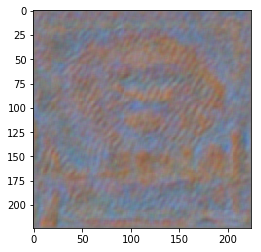

Epoch 1/10
1/1 [==============================] - 6s - loss: 135197.7031
Epoch 2/10
1/1 [==============================] - 6s - loss: 127742.3359
Epoch 3/10
1/1 [==============================] - 6s - loss: 119146.7266
Epoch 4/10
1/1 [==============================] - 6s - loss: 110540.8203
Epoch 5/10
1/1 [==============================] - 6s - loss: 102745.6719
Epoch 6/10
1/1 [==============================] - 6s - loss: 95958.6484
Epoch 7/10
1/1 [==============================] - 6s - loss: 89978.5312
Epoch 8/10
1/1 [==============================] - 6s - loss: 84362.0078
Epoch 9/10
1/1 [==============================] - 6s - loss: 79242.3125
Epoch 10/10
1/1 [==============================] - 6s - loss: 74701.5781
(224, 224, 3)


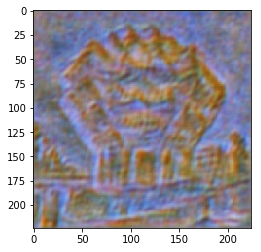

Epoch 1/10
1/1 [==============================] - 6s - loss: 70659.0859
Epoch 2/10
1/1 [==============================] - 6s - loss: 67177.4297
Epoch 3/10
1/1 [==============================] - 6s - loss: nan
Epoch 4/10
1/1 [==============================] - 6s - loss: nan
Epoch 5/10
1/1 [==============================] - 6s - loss: nan
Epoch 6/10
1/1 [==============================] - 6s - loss: nan
Epoch 7/10
1/1 [==============================] - 6s - loss: nan
Epoch 8/10
1/1 [==============================] - 6s - loss: nan
Epoch 9/10
1/1 [==============================] - 6s - loss: nan
Epoch 10/10
1/1 [==============================] - 6s - loss: nan
(224, 224, 3)


KeyboardInterrupt: 

In [314]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 10)
    img = generative_model.predict(trainX3) * 0.5 + 0.5
    img = img[0]
    print img.shape
    # img = img.swapaxes(0, 2)#.swapaxes(0, 1)
    plt.imshow(img)
    plt.show()
 

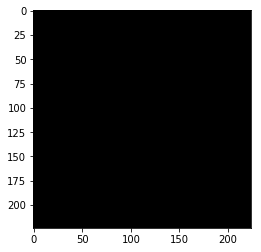

In [283]:
img = generative_model.predict(trainX3)
img = img[0]
# img = img.swapaxes(0, 2)#.swapaxes(0, 1)
plt.imshow(img)
plt.show()


In [228]:
np.max(img[:, :, 2]), np.min(img[:, :, 2])

(0.63949114, 0.36034799)